## Authorship Information
__author__ = "Arif Haidari"<br>
__credits__ = ["Bernd Brinkmann", "Luigi Menale", "Alex Tavkhelidze", "Romain Lesieur"]<br>
__status__ = "Development"<br>
__project__ = "Plant Recognition"<br>
__scope__ = "DataScientest's Bootcamp in Data Science"

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# training a deep learning model with subset of the database (apple_recognition) for benchmarking

In [ ]:
# directories
data_dir = '/content/drive/MyDrive/raw_dataset/apple_recognition/'

In [ ]:

# Data preprocessing

img_size = (256, 256)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Train model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Save model
model.save('/content/drive/MyDrive/colab_notebook/deep_learning_model.h5')


Found 1474 images belonging to 4 classes.
Found 366 images belonging to 4 classes.
Epoch 1/50
47/47 [==============================] - 454s 10s/step - loss: 1.1490 - accuracy: 0.5217 - val_loss: 0.6319 - val_accuracy: 0.7486 - lr: 0.0010
Epoch 2/50
47/47 [==============================] - 310s 7s/step - loss: 0.5625 - accuracy: 0.7863 - val_loss: 0.5145 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 3/50
47/47 [==============================] - 319s 7s/step - loss: 0.4445 - accuracy: 0.8372 - val_loss: 0.3687 - val_accuracy: 0.8415 - lr: 0.0010
Epoch 4/50
47/47 [==============================] - 341s 7s/step - loss: 0.3812 - accuracy: 0.8596 - val_loss: 0.4731 - val_accuracy: 0.8060 - lr: 0.0010
Epoch 5/50
47/47 [==============================] - 306s 7s/step - loss: 0.4069 - accuracy: 0.8399 - val_loss: 0.2750 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 6/50
47/47 [==============================] - 308s 7s/step - loss: 0.3316 - accuracy: 0.8765 - val_loss: 0.2198 - val_accuracy: 0.9317 - lr:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Function to Extract Class Names from a Dataset and Save Them

In [ ]:

import json
import csv

# Function to extract class names and save to JSON and CSV
def save_class_names(data_dir, output_json_path):
    class_names = {}
    for idx, label in enumerate(sorted(os.listdir(data_dir))):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            class_names[label] = idx

    # Save to JSON
    with open(output_json_path, 'w') as json_file:
        json.dump(class_names, json_file)


    return class_names

# Example usage
output_json_path = '/content/drive/MyDrive/colab_notebook/class_indices.json'  # Path to save the class indices JSON file

class_names = save_class_names(data_dir, output_json_path)
print(f'Class names and indices have been saved to {output_json_path}')




Class names and indices have been saved to /content/drive/MyDrive/colab_notebook/class_indices.json and /content/drive/MyDrive/colab_notebook/class_indices.csv


In [ ]:
# Function to Predict the Class of an Input Image

In [ ]:
import json
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to preprocess input image
def preprocess_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Normalize the image
    return image

# Function to load the model and predict the category
def predict_image_category(image_path, model_path, class_indices_path):
    # Load the saved model
    model = tf.keras.models.load_model(model_path)

    # Load the class indices
    with open(class_indices_path, 'r') as file:
        class_indices = json.load(file)

    # Preprocess the image
    image = preprocess_image(image_path)

    # Make prediction
    predictions = model.predict(image)

    # Get the class label
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    class_label = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index)]

    return class_label

# Example usage
model_path = '/content/drive/MyDrive/colab_notebook/plant_detection_model.h5'  # Path to the saved model
image_path = '/content/drive/MyDrive/raw_dataset/test/image (953).JPG'    # Path to the input image
class_indices_path = '/content/drive/MyDrive/colab_notebook/class_indices.json'  # Path to the saved class indices JSON file

predicted_category = predict_image_category(image_path, model_path, class_indices_path)
print(f'The input image belongs to the category: {predicted_category}')


# correct prediction:
# AppleCedarRust1.JPG
# Apple___Cedar_apple_rust
# AppleScab3.JPG
# Apple___Apple_scab
# image (954).JPG
# Apple___healthy

# image from internet
# 2-black_rot.jpeg
# Apple___Black_rot
# 1-cedar_rust.jpeg
# Apple___Cedar_apple_rust
# 1-black_rot ---------> correct here
# Apple___Black_rot
# apple-1.jpeg ----> dark leaf
# Apple___healthy
# ==============================

# Wrong Prediction - Limitation:
# photo from Internet
# 2-cedar_rust.jpeg
# Apple___Black_rot
# 3-cedar_rust.jpeg
# Apple___Black_rot
# apple-2.jpeg ---> more than one leaves
#  Apple___Apple_scab
# apple-3.jpeg ----> more than one leaves
# Apple___Black_rot
# apple-4.jpeg ---> with noise -- with rain drops on it
# Predicted class: Apple___Apple_scab
# apple-5.jpeg
# Apple___Black_rot

1/1 [==============================] - 1s 561ms/step
The input image belongs to the category: Apple___healthy


In [ ]:
# XGBClassifier Output:
# Correct prediction:
# AppleCedarRust1.JPG
# Predicted class: Apple___Cedar_apple_rust
# AppleScab3.JPG
# Predicted class: Apple___Apple_scab
# image (954).JPG
# Predicted class: Apple___healthy

# photo from google:
# 2-black_rot.jpeg
# Predicted class: Apple___Black_rot
# 1-cedar_rust.jpeg
# Predicted class: Apple___Cedar_apple_rust
# 2-cedar_rust.jpeg
# Predicted class: Apple___Cedar_apple_rust
# ==============================

# Wrong Prediction - Limitation:
# photo from Internet
# 1-black_rot.jpeg
# Predicted class: Apple___Cedar_apple_rust
# 3-cedar_rust.jpeg
# Predicted class: Apple___Black_rot
# apple-1.jpeg ----> dark leaf
# Predicted class: Apple___Cedar_apple_rust
# apple-2 ---> more than one leaves
# Predicted class: Apple___Cedar_apple_rust
# apple-3 ----> more than one leaves
# Predicted class: Apple___Cedar_apple_rust
# apple-4 ---> with noise -- with rain drops on it
# Predicted class: Apple___Apple_scab
# apple-5
# Predicted class: Apple___Cedar_apple_rust

In [ ]:
# Visualisation the findings

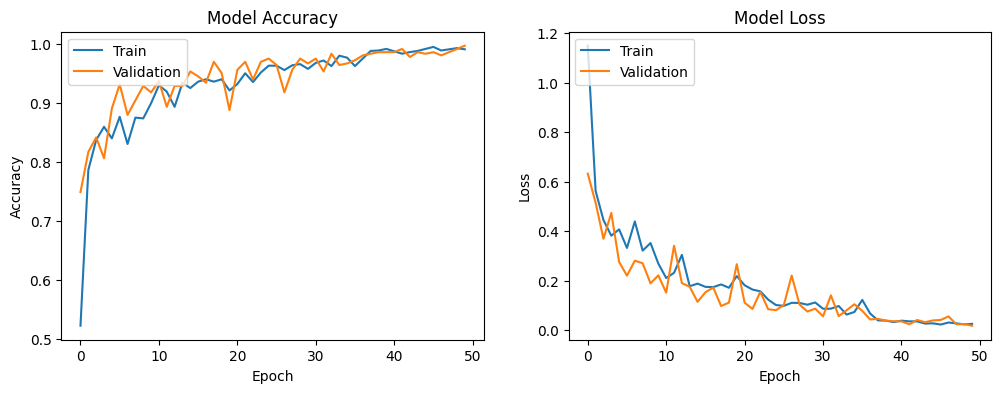

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to plot training & validation accuracy and loss
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


# Example usage
# Assuming `history` is the variable storing the training history from the deep learning model
plot_training_history(history)



In [ ]:
# Assuming `validation_generator` is used for generating the validation data and has labels

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to display classification report
def display_classification_report(y_true, y_pred, class_labels):
    print(classification_report(y_true, y_pred, target_names=class_labels))


y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, class_labels)

# Display classification report
display_classification_report(y_true, y_pred_classes, class_labels)

In [ ]:
# Confusion Matrix
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices, yticklabels=validation_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Classification Report
class_report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys())
print("Classification Report:\n", class_report)